# Random Forest

## Import and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
housing_prices_df_raw = pd.read_csv('../src/data/train.csv')
test_housing_prices_df_raw = pd.read_csv('../src/data/test.csv')

In [3]:
train_hdf = housing_prices_df_raw.copy()
test_hdf = test_housing_prices_df_raw.copy()

In [4]:
hdf = pd.concat([train_hdf, test_hdf], axis = 0, sort = False)
hdf_eda = hdf.copy()

### Helper functions

In [5]:
# Show all rows and columns of data frame
def print_full(x):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')

# Feature importance plots
def feat_df(feature_names, importances):
    df=pd.DataFrame({'feature': feature_names,
                     'importance': importances}).sort_values('importance', ascending=False).reset_index(drop=True)
    return df

def plot_imp(feat_df, title):
    feat_df.columns=['feature', 'importance']
    sns.barplot(x='importance', y='feature', data=feat_df, orient='h',palette='Spectral').set_title(title, fontsize = 20)
    sns.set(rc = {'figure.figsize':(10, 10)})

## Inspect data frame

In [6]:
hdf.shape

(2919, 81)

In [7]:
hdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [8]:
hdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

## Identify features by variable type

In [9]:
ord_feat_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 
        'BsmtHalfBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces', 'BedroomAbvGr', 
        'KitchenAbvGr', 'GarageCars']

ord_feat_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC']

ord_feat = ord_feat_num + ord_feat_cat

nom_feat = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 
       'LandContour', 'Utilities', 'Neighborhood', 
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 
       'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 
       'HouseStyle','LotConfig', 'Street', 'LandSlope']

cont_feat = ['LotFrontage', 'LotArea', 'YearBuilt', 
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
       'MiscVal', 'MoSold', 'YrSold','BsmtUnfSF', 'GarageArea', 
       'LowQualFinSF', 'GrLivArea']

## Data cleaning

### Impute missing values

In [10]:
# Check NAs by count
NA_count = hdf.isnull().sum()[hdf.isnull().sum() > 0]

# By percentage
round(100*NA_count/len(hdf), 2)

MSZoning         0.14
LotFrontage     16.65
Alley           93.22
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.77
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.65
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.66
Fence           80.44
MiscFeature     96.40
SaleType         0.03
SalePrice       49.98
dtype: float64

Impute missing values for `LotFrontage`:

In [11]:
hdf['LotFrontage'] = hdf.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median))

Insert text here later:

In [12]:
# Convert ord_feat_num to ord_feat
hdf[ord_feat_cat] = hdf[ord_feat_cat].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
hdf[['BsmtExposure']] = hdf[['BsmtExposure']].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
hdf[['BsmtFinType1', 'BsmtFinType2']] = hdf[['BsmtFinType1', 'BsmtFinType2']].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})

In [13]:
# Convert fence to nominal
hdf[['Fence']] = hdf[['Fence']].replace({'MnPrv': 'HasFence', 'GdWo': 'HasFence', 'GdPrv': 'HasFence', 'MnWw': 'HasFence', np.nan: 'NoFence'})

Impute missing values for remaining columns:

In [14]:
from scipy import stats

In [15]:
for col in set(hdf.columns) - {'SalePrice'}:
    if hdf[col].dtype == 'object':
        hdf.fillna({col:stats.mode(hdf[col]).mode[0]}, inplace = True)
    else:
        hdf.fillna({col:np.median(hdf.loc[~hdf[col].isnull(), col])}, inplace = True)

## Data preprocessing

### Generate features

In [16]:
hdf['Remodeled'] = pd.Series([1 if a > 0 else 0 for a in (hdf['YearRemodAdd'] - hdf['YearBuilt'])])
hdf['TotalPorchAreasSF'] = hdf['OpenPorchSF'] + hdf['EnclosedPorch'] + hdf['3SsnPorch'] + hdf['ScreenPorch'] + hdf['WoodDeckSF']
hdf ['TotalBath'] = hdf['FullBath'] + hdf['BsmtFullBath'] + .5*(hdf['HalfBath'] + hdf['BsmtHalfBath'])
hdf['OtherRoomsAbvGrd'] = hdf['TotRmsAbvGrd'] - hdf['KitchenAbvGr'] - hdf['FullBath']

Drop redundant features:

In [17]:
hdf.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace = True)
hdf.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace = True) # There is totalbsmt
hdf.drop(columns = ['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'], inplace = True)
hdf.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], inplace = True)
hdf.drop(columns = 'MiscFeature', inplace = True) # Drop feature (since price of feature is in Miscval)
hdf.drop(columns = 'TotRmsAbvGrd', inplace = True)

Check for NAs:

In [18]:
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

SalePrice    49.98
dtype: float64

Trim feature list:

In [19]:
ord_feat_num = set(ord_feat_num).union(set(['TotalBath', 'OtherRoomsAbvGrd', 'Remodeled'])) - \
set(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',' KitchenAbvGr', 'GarageCars'])

ord_feat_cat = set(ord_feat_cat) - set(['PoolQC'])

ord_feat = ord_feat_num.union(ord_feat_cat)

nom_feat = set(nom_feat) - set(['Utilities','MiscFeature','Street'])

cont_feat = list(set(cont_feat).union(set(['TotalPorchAreasSF'])) - set(['Utilities', 'Street', 'PoolQC'] +\
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] +\
['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'] +\
['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'] +\
['MiscFeature', 'TotRmsAbvGrd']))

### Define features and target

Define training data features and target:

In [20]:
# Define training data features
X_train = hdf.loc[~hdf['SalePrice'].isnull(), :]
# Drop outliers
# X_train = X_train.loc[(X_train['GrLivArea'] < 4000) & (X_train['LotArea'] < 100000) & (X_train['LotFrontage'] < 250),:]

# Define training data target
y_train = np.log1p(X_train.loc[~X_train['SalePrice'].isnull(), 'SalePrice'])

# Drop unnecessary columns
X_train.drop(columns = ['SalePrice'], inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Define test data features and target:

In [21]:
X_test = hdf.loc[hdf['SalePrice'].isnull(), :].drop(columns = ['SalePrice'])

Check dimensions of training and testing sets:

In [22]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (1460, 67)
Training Target Shape: (1460,)
Testing Features Shape: (1459, 67)


### Encode categorical features

Identify features by variable type:

In [23]:
import category_encoders as ce

#### Ordinal

- Ordinal Encoder: [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

In [24]:
ord_enc = ce.OrdinalEncoder(cols=ord_feat).fit(X_train,y_train)
X_train = ord_enc.transform(X_train)

X_test = ord_enc.transform(X_test)

#### Nominal

- CatBoost Encoder: [Documentation](https://contrib.scikit-learn.org/categorical-encoding/catboost.html), [explanation via example](https://medium.com/whats-your-data/working-with-categorical-data-catboost-8b5e11267a37)

In [25]:
perm = np.random.permutation(len(X_train))
X_train = X_train.iloc[perm].reset_index(drop=True)
y_train = y_train.iloc[perm].reset_index(drop=True)

nom_enc = ce.CatBoostEncoder(cols=nom_feat).fit(X_train,y_train)
X_train = nom_enc.transform(X_train)

X_test = nom_enc.transform(X_test)

In [27]:
X_train.drop(columns = ['Id'], inplace = True)

## Model

In [28]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [29]:
# Create base model
rf = RandomForestRegressor(random_state = 999, oob_score = True)

In [30]:
# Check out base/default parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': True,
 'random_state': 999,
 'verbose': 0,
 'warm_start': False}


### Choose hyperparameters

#### Randomized Search

Narrow down search for wide range of values for hyperparameters:

In [31]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 3500, num = 10)]
# Criterion
criterion = ['mse', 'mae']
# Number of features to consider at every split
max_features = [7, 8, 9, 10, 11, 12, 15, 16, 20, 22]
# Minimum number of samples required to split a node
min_samples_split = np.arange(8,11,1)

In [33]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'min_samples_split': min_samples_split
              }

In [34]:
pprint(random_grid)

{'criterion': ['mse', 'mae'],
 'max_features': [7, 8, 9, 10, 11, 12, 15, 16, 20, 22],
 'min_samples_split': array([ 8,  9, 10]),
 'n_estimators': [2000, 2166, 2333, 2500, 2666, 2833, 3000, 3166, 3333, 3500]}


In [35]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 5-fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 85.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=True,
                                                   random_stat...e

In [36]:
rf_random.best_params_

{'n_estimators': 3166,
 'min_samples_split': 8,
 'max_features': 22,
 'criterion': 'mse'}

In [70]:
random_scores = pd.DataFrame(rf_random.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
random_scores = random_scores.set_index(['rank_test_score', 'mean_test_score', 'std_test_score']).params.apply(pd.Series).reset_index()
random_scores_top_10 = random_scores.sort_values('rank_test_score')[:11]
random_scores_top_10

,rank_test_score,mean_test_score,std_test_score,n_estimators,min_samples_split,max_features,criterion
43,1,0.876456,0.017853,3166,8,22,mse
24,2,0.876433,0.017852,3333,8,22,mse
88,3,0.876408,0.017853,2666,8,22,mse
9,4,0.876302,0.018174,2500,8,20,mse
92,5,0.876165,0.018160,3333,8,20,mse
82,6,0.876136,0.017993,2833,8,16,mse
81,7,0.876090,0.018059,2000,8,16,mse
4,8,0.875955,0.017620,3166,9,22,mse
31,9,0.875924,0.017600,2500,9,22,mse
94,10,0.875799,0.017594,2666,9,20,mse


Calculate R^2 (coefficient of determination) score of model and mean training error:

In [39]:
from sklearn.metrics import r2_score

In [40]:
print('The R^2 score of rf_random model is: %.5f' %(r2_score(y_train, rf_random.predict(X_train))))
print('The mean test score of rf_random model is: %.5f' %(rf_random.best_score_))
print("The training error of rf_random model is: %.5f" %(1 - rf_random.score(X_train, y_train)))

The R^2 score of rf_random model is: 0.96876
The mean test score of rf_random model is: 0.87646
The training error of rf_random model is: 0.03124


#### Grid Search

Evaluate combination of settings from randomized search:

In [72]:
from sklearn.model_selection import GridSearchCV

In [94]:
random_scores_top_10.describe()

,rank_test_score,mean_test_score,std_test_score,n_estimators,min_samples_split,max_features
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,6.000000,0.876131,0.017848,2817.818182,8.363636,20.181818
std,3.316625,0.000248,0.000229,411.179722,0.504525,2.272364
min,1.000000,0.875780,0.017572,2000.000000,8.000000,16.000000
25%,3.500000,0.875939,0.017610,2583.000000,8.000000,20.000000
50%,6.000000,0.876136,0.017853,2833.000000,8.000000,20.000000
75%,8.500000,0.876355,0.018026,3166.000000,9.000000,22.000000
max,11.000000,0.876456,0.018174,3333.000000,9.000000,22.000000


In [103]:
param_grid = {
    'max_features': [16, 18, 20, 22],
    'min_samples_split': [8, 9, 10],
    'n_estimators': [2000, 2666, 2700, 3166]
}

In [104]:
# Use gridSearchCV to search to narrow down parameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=True, random_state=999,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': [19, 20, 22],
     

In [105]:
grid_search.best_params_

{'max_features': 22, 'min_samples_split': 8, 'n_estimators': 3166}

In [115]:
grid_scores = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
grid_scores = grid_scores.set_index(['rank_test_score', 'mean_test_score', 'std_test_score']).params.apply(pd.Series).reset_index()
grid_scores.sort_values('rank_test_score')[:11]

,rank_test_score,mean_test_score,std_test_score,max_features,min_samples_split,n_estimators
20,1,0.876456,0.017853,22,8,3166
18,2,0.876408,0.017853,22,8,2666
19,3,0.876402,0.017882,22,8,2700
10,4,0.876255,0.018202,20,8,2700
9,5,0.876254,0.018196,20,8,2666
2,6,0.876246,0.018153,19,8,3166
1,7,0.876178,0.018110,19,8,2700
0,8,0.876174,0.018118,19,8,2666
11,9,0.876159,0.018151,20,8,3166
23,10,0.875955,0.017620,22,9,3166


Calculate R^2 (coefficient of determination) score, mean test score, and mean training error of `grid_search` model using best parameters:

In [108]:
print('The R^2 score of grid_search model is: %.5f' %(r2_score(y_train, grid_search.predict(X_train))))
print('The mean test score of grid_search model is: %.5f' %(grid_search.best_score_))
print('The training error of grid_search model is: %.5f' %(1 - grid_search.score(X_train, y_train)))

The R^2 score of grid_search model is: 0.96876
The mean test score of grid_search model is: 0.87646
The training error of grid_search model is: 0.03124


### Make predictions

Predict test values:

In [119]:
y_predict = np.expm1(grid_search.predict(X_test.drop(columns = 'Id')))

In [120]:
price = pd.DataFrame(y_predict, columns=['SalePrice'])

results = pd.concat([X_test['Id'], price['SalePrice']], axis=1)
results

,Id,SalePrice
0,1461,123363.153829
1,1462,152844.972783
2,1463,186605.605838
3,1464,189418.864573
4,1465,194554.005132
...,...,...
1454,2915,84968.101800
1455,2916,84810.489852
1456,2917,156699.748789
1457,2918,113811.668397


## Feature importance

### Measure: mean decrease in purity

Calculate feature importance using `sklearn`'s default:

In [121]:
rf_features = list(X_train.columns)

importances = list(grid_search.best_estimator_.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature,
                      importance in zip(rf_features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances][0]

Feature: Neighborhood         Importance: 0.2
Feature: GrLivArea            Importance: 0.18
Feature: YearBuilt            Importance: 0.09
Feature: TotalBsmtSF          Importance: 0.06
Feature: GarageCars           Importance: 0.06
Feature: 1stFlrSF             Importance: 0.05
Feature: GarageArea           Importance: 0.05
Feature: OverallQual          Importance: 0.03
Feature: GarageYrBlt          Importance: 0.03
Feature: GarageFinish         Importance: 0.03
Feature: LotArea              Importance: 0.02
Feature: YearRemodAdd         Importance: 0.02
Feature: 2ndFlrSF             Importance: 0.02
Feature: MSSubClass           Importance: 0.01
Feature: LotFrontage          Importance: 0.01
Feature: ExterQual            Importance: 0.01
Feature: Foundation           Importance: 0.01
Feature: BsmtQual             Importance: 0.01
Feature: CentralAir           Importance: 0.01
Feature: KitchenQual          Importance: 0.01
Feature: Fireplaces           Importance: 0.01
Feature: Firep

### Measure: Permutation importance

Calculate permutation feature importance using `rfpimp`:

In [145]:
from rfpimp import *

In [123]:
def r2(grid_search, X_train, y_train):
    return r2_score(y_train, grid_search.predict(X_train))

rfpimp_perm = permutation_importances(grid_search, X_train, y_train, r2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  6.2min finished


In [124]:
print_full(rfpimp_perm.reset_index().sort_values(by='Importance', ascending = False))

              Feature  Importance
0           GrLivArea    0.167501
1        Neighborhood    0.100848
2         TotalBsmtSF    0.035136
3            1stFlrSF    0.029909
4           YearBuilt    0.029452
5         OverallQual    0.022041
6          GarageCars    0.017934
7          GarageArea    0.017786
8        YearRemodAdd    0.011727
9             LotArea    0.010924
10           2ndFlrSF    0.008744
11         Fireplaces    0.008520
12        GarageYrBlt    0.008155
13        FireplaceQu    0.007117
14       GarageFinish    0.007007
15         MSSubClass    0.006839
16         CentralAir    0.006472
17  TotalPorchAreasSF    0.006131
18          TotalBath    0.004067
19        LotFrontage    0.003992
20        OverallCond    0.003441
21           MSZoning    0.003133
22        KitchenQual    0.003081
23           BsmtQual    0.002943
24          ExterQual    0.002884
25       BsmtFinType1    0.002769
26         MasVnrArea    0.001962
27             MoSold    0.001902
28      SaleCo

### Measure: Drop-column importance

Use `rfpimp`'s drop-column importance to investigate feature importance by comparing a reduced model with one column dropped to the saturated model via performance score:

In [125]:
# Recreate grid_search model by using best parameters for saturated model
rf_saturated = RandomForestRegressor(n_estimators = 2650, min_samples_split = 6, 
                                     max_features = 22, random_state = 999,
                                     oob_score = True, n_jobs = -1)

In [126]:
# Using function from rfpimp package

def dropcol_importances(rf, X_train, y_train):
    from sklearn.base import clone
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

drop_col_feat = dropcol_importances(rf_saturated, X_train, y_train)

In [127]:
print_full(drop_col_feat.sort_values('Importance', ascending = False))

                   Importance
Feature                      
Neighborhood         0.009416
GrLivArea            0.007676
OverallQual          0.004039
OverallCond          0.001994
YearRemodAdd         0.001949
CentralAir           0.001868
MSZoning             0.001851
BsmtFinType1         0.001754
LotArea              0.001219
YearBuilt            0.001160
TotalBsmtSF          0.000957
BsmtFinType2         0.000897
TotalPorchAreasSF    0.000896
BsmtCond             0.000884
KitchenQual          0.000842
Foundation           0.000826
HeatingQC            0.000755
BsmtExposure         0.000732
TotalBath            0.000680
Fireplaces           0.000663
RoofMatl             0.000621
BedroomAbvGr         0.000558
Exterior1st          0.000531
BsmtQual             0.000521
FireplaceQu          0.000490
Exterior2nd          0.000475
ExterQual            0.000473
Heating              0.000458
Functional           0.000415
GarageFinish         0.000408
SaleCondition        0.000374
PavedDrive

### Conditional feature importance

Identify indexes with the lowest and highest absolute prediction errors, which represent best and worst predictions:

In [129]:
pred_diff = pd.DataFrame({'difference': abs(y_train - rf_saturated.fit(X_train, y_train).predict(X_train))})

print('Index with smallest error:', pred_diff.sort_values('difference').head(1).index.values[0])
print('Inxex with largest error:', pred_diff.sort_values('difference', ascending = False).head(1).index.values[0])

Index with smallest error: 133
Inxex with largest error: 1454


Explanation here:

In [131]:
from treeinterpreter import treeinterpreter as ti, utils

In [132]:
selected_rows = [133, 1454]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf_saturated, selected_df)

for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0])
    print("Actual Value:", y_train[selected_rows[i]])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Row 133
Prediction: 11.63504803756224
Actual Value: 11.635151947212842
Bias (trainset mean) 12.024083906177005
Feature contributions:
Neighborhood -0.14
GrLivArea -0.11
YearBuilt -0.06
MSSubClass -0.03
GarageCars -0.03
FireplaceQu 0.02
Fireplaces 0.02
GarageFinish -0.02
YearRemodAdd -0.02
TotalBsmtSF 0.02
OverallQual 0.02
CentralAir 0.01
GarageYrBlt -0.01
BsmtCond -0.01
GarageArea -0.01
LotFrontage -0.01
2ndFlrSF -0.01
LotArea -0.01
TotalBath -0.01
OverallCond 0.01
GarageQual 0.01
GarageCond 0.01
Foundation -0.0
1stFlrSF -0.0
BedroomAbvGr -0.0
MSZoning -0.0
SaleCondition 0.0
PavedDrive 0.0
HeatingQC -0.0
BsmtFinType1 -0.0
Electrical -0.0
Condition1 0.0
BsmtQual 0.0
Functional 0.0
HouseStyle 0.0
TotalPorchAreasSF -0.0
GarageType -0.0
ExterQual -0.0
MiscVal 0.0
OtherRoomsAbvGrd -0.0
Exterior1st 0.0
YrSold -0.0
Fence -0.0
Exterior2nd 0.0
SaleType 0.0
ExterCond 0.0
KitchenQual -0.0
BsmtExposure 0.0
Condition2 0.0
Heating 0.0
MasVnrArea -0.0
MoSold 0.0
LotShape -0.0
LowQualFinSF 0.0
MasVnrT

In [133]:
prediction1, bias1, contributions1 = ti.predict(rf_saturated, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf_saturated, np.array([selected_df[1]]), joint_contribution=True)

In [134]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [135]:
print (np.sum(list(aggregated_contributions1.values())) - 
       np.sum(list(aggregated_contributions2.values())))
print (np.mean(prediction1) - np.mean(prediction2))

-0.08612407754252877
-0.08612407754252693


In [136]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['Neighborhood'] [-0.16723725]
['GarageFinish'] [-0.03454075]
['GarageCars'] [-0.02320638]
['Neighborhood', 'GrLivArea'] [-0.01966026]
['YearBuilt', 'GrLivArea'] [-0.0183519]
['TotalBsmtSF'] [-0.01259674]
['TotalBsmtSF', 'GrLivArea'] [-0.00869977]
['YearBuilt', '1stFlrSF'] [-0.00817919]
['GarageArea'] [-0.00757325]
['Neighborhood', 'GarageCars'] [0.00743535]


### Investigating collinearity and feature dependence

Based on 

In [138]:
feature_corr_matrix(X_train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Remodeled,TotalPorchAreasSF,TotalBath,OtherRoomsAbvGrd
MSSubClass,1.0000,0.3550,0.3052,0.2592,0.1158,0.2721,0.1152,0.0800,-0.0175,0.5348,...,0.0995,-0.0496,0.0385,-0.0137,0.1840,0.2062,-0.2386,0.2766,-0.4236,-0.0814
MSZoning,0.3550,1.0000,0.3037,0.2677,-0.1460,0.1873,0.0654,0.0594,-0.0089,0.5710,...,0.0584,-0.0232,-0.0028,0.0144,0.1828,0.1733,-0.2097,0.0743,-0.2997,-0.0050
LotFrontage,0.3052,0.3037,1.0000,0.6094,0.1928,0.1614,0.0763,0.1274,0.0578,0.3314,...,-0.0476,0.0292,0.0163,0.0021,0.0857,0.0973,-0.1107,0.1684,-0.1732,-0.0897
LotArea,0.2592,0.2677,0.6094,1.0000,0.1618,0.3414,0.1375,0.2192,0.1169,0.3043,...,0.0363,0.0593,0.0064,-0.0275,0.0696,0.0813,-0.0151,0.2466,-0.1539,-0.0700
Alley,0.1158,-0.1460,0.1928,0.1618,1.0000,0.0477,0.0597,0.0470,0.0038,-0.0254,...,-0.0409,0.0327,0.0214,0.0002,-0.0466,-0.0116,-0.0536,0.0110,0.0471,-0.0953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition,0.2062,0.1733,0.0973,0.0813,-0.0116,0.0591,0.0771,-0.0430,-0.0589,0.2850,...,0.1542,-0.0213,0.0584,-0.0505,0.6730,1.0000,-0.0074,0.0706,-0.1588,-0.0592
Remodeled,-0.2386,-0.2097,-0.1107,-0.0151,-0.0536,-0.0724,-0.0543,-0.0193,0.0354,-0.1974,...,-0.0767,0.0173,-0.0071,0.0218,-0.0046,-0.0074,1.0000,0.0497,0.1406,-0.0275
TotalPorchAreasSF,0.2766,0.0743,0.1684,0.2466,0.0110,0.1605,0.0511,0.0758,0.0611,0.2251,...,-0.0129,0.0207,0.0480,-0.0033,0.0809,0.0706,0.0497,1.0000,-0.1834,-0.0034
TotalBath,-0.4236,-0.2997,-0.1732,-0.1539,0.0471,-0.1414,-0.0967,-0.0423,0.0063,-0.3914,...,-0.1003,0.0439,-0.0043,-0.0249,-0.1513,-0.1588,0.1406,-0.1834,1.0000,0.0344


In [139]:
feat_dep = feature_dependence_matrix(X_train, sort_by_dependence=True)
print_full(feat_dep['Dependence'].sort_values(ascending=False))

GrLivArea              0.970151
2ndFlrSF                0.96301
MSSubClass             0.952888
YearBuilt                0.9407
1stFlrSF               0.916248
HouseStyle             0.881021
GarageCars             0.879506
SaleType               0.877847
Exterior2nd            0.873116
Exterior1st            0.872301
BldgType               0.867575
MasVnrType             0.852678
GarageYrBlt            0.833631
GarageArea             0.825331
Fireplaces             0.822689
TotalBsmtSF            0.812166
SaleCondition          0.797618
GarageQual              0.78315
Neighborhood           0.782615
MSZoning               0.756736
YearRemodAdd             0.7205
FireplaceQu            0.708624
Foundation             0.655263
KitchenAbvGr           0.629247
Remodeled              0.627443
GarageCond             0.622518
MasVnrArea             0.621664
GarageType             0.610026
GarageFinish           0.568459
LotArea                0.513377
Alley                  0.495184
ExterQua

## Submission

In [140]:
submission = pd.DataFrame({'Id': X_test['Id'], 
                           'SalePrice': y_predict})

submission.to_csv('submission_rf_3.csv', index=False)

## Data visualization

### Feature importance

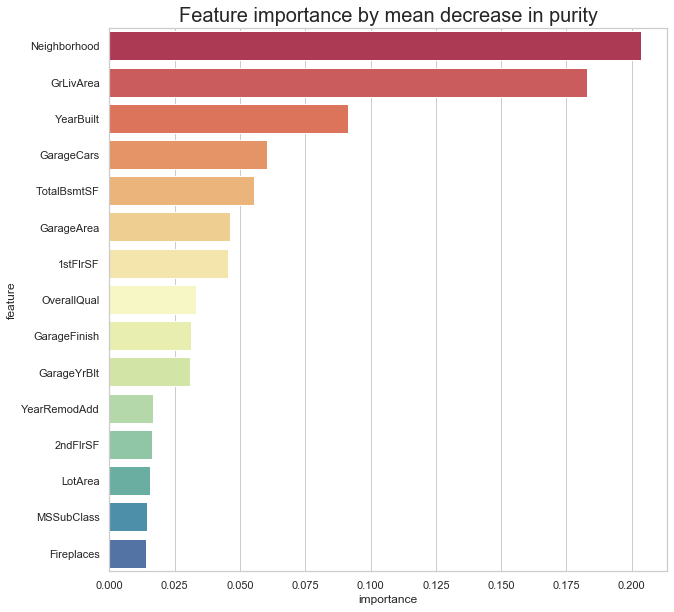

In [236]:
sk_feat_imp = feat_df(X_train.columns, grid_search.best_estimator_.feature_importances_)
plot_imp(sk_feat_imp[:15], 'Feature importance by mean decrease in purity')
sns.set_style("whitegrid")

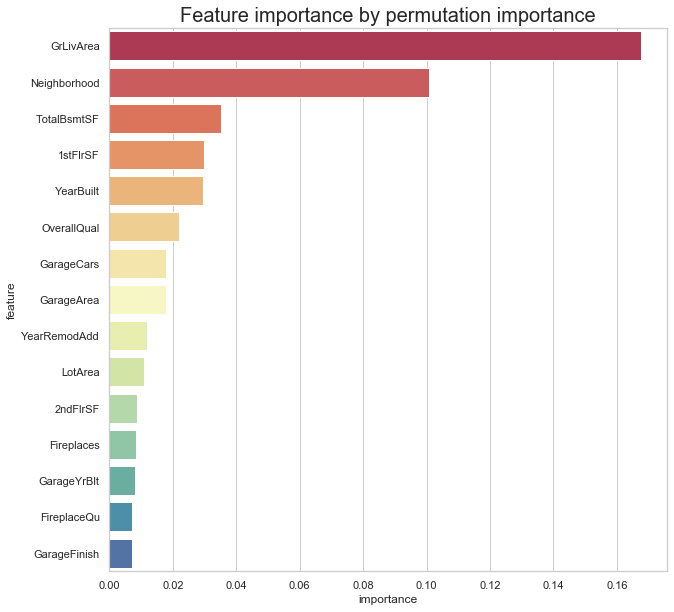

In [237]:
plot_imp(rfpimp_perm[:15], 'Feature importance by permutation importance')
sns.set_style("whitegrid")

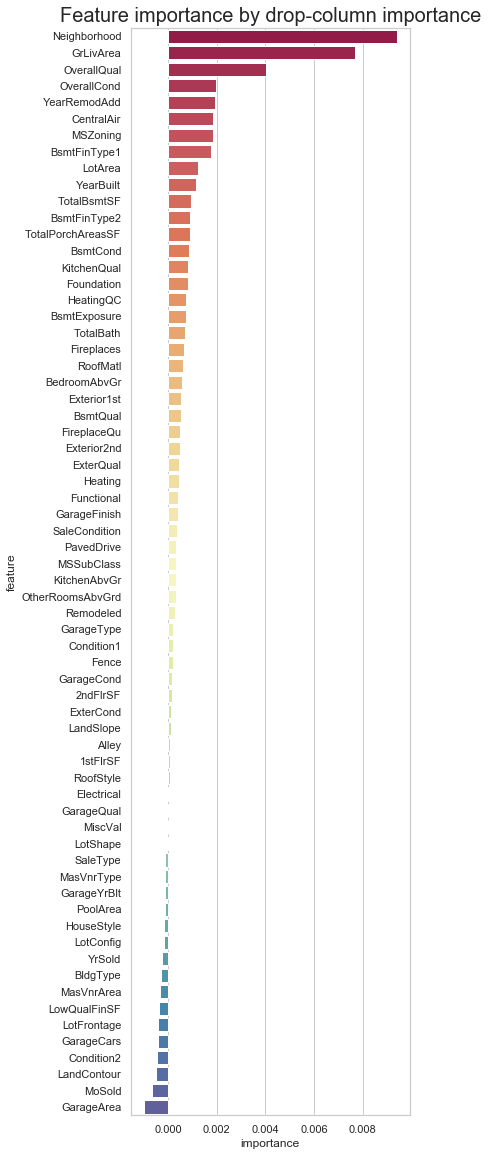

In [259]:
drop_col_feat.reset_index()
plot_imp(drop_col_feat.reset_index().sort_values('Importance', ascending = False), 'Feature importance by drop-column importance')
sns.set(rc = {'figure.figsize':(10, 20)})
sns.set_style("whitegrid")